Step 3: loss = 1.7695e-10
Error: 1.102e-04


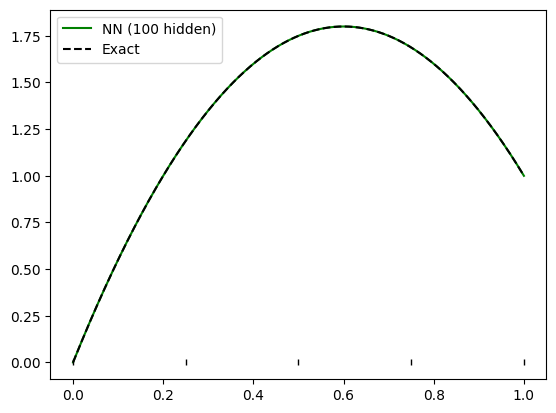

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)

# Problem (1D Poisson equation)
# 
# Find f s.t.
#   -f''(x) = q, on [0,1]
# with f(0) = 0, f(1) = 1, and q = 10.
#

# Exact solution
f = lambda x: (6 - 5 * x) * x

# Boudnary condition
bc = lambda x: x

# Source
q = lambda x: 10

# Domain
xl = 0.
xr = 1.


# Number of hidden nodes (governs the precision)
hidden_size = 100

# Define the model (single-layer perceptron with tanh, universal approximator)
class Model(nn.Module):
    def __init__(self, hidden_size):
        super(Model, self).__init__()
        self.input = nn.Linear(1, hidden_size, bias=True)
        self.output = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, x):
        x = self.input(x)
        x = torch.tanh(x)
        x = self.output(x)
        return x


# Initialize the model
model = Model(hidden_size)

# Points used for loss evaluation
x_train = np.linspace(xl, xr, 5)

# Points used for error and visualization
x_test = np.linspace(xl, xr, 1000)
y_test = f(x_test)

# Convert to tensors
x_train_1 = torch.from_numpy(x_train).float().unsqueeze(1)
x_test_1 = torch.from_numpy(x_test).float().unsqueeze(1)
y_test_1 = torch.from_numpy(y_test).float().unsqueeze(1)


# Define the loss function and the optimizer
optimizer = torch.optim.LBFGS(model.parameters())

curr_loss = 1
step = 0

# Train the model
print("", end="")
while curr_loss > 1e-8 and step < 100:
    step += 1

    def closure():
        optimizer.zero_grad()
        loss = 0

        # Boundary conditions
        pred = model(x_train_1)
        loss += (pred[0] - bc(x_train[0]))**2
        loss += (pred[-1] - bc(x_train[-1]))**2

        # Minus second derivative equals source term
        for xi in x_train:
            x_deriv = torch.tensor([[float(xi)]], requires_grad=True)
            y_deriv = model(x_deriv)
            d1 = torch.autograd.grad(y_deriv, x_deriv, create_graph=True)[0]
            d2 = torch.autograd.grad(d1, x_deriv, create_graph=True)[0]
            loss += (-d2[0] - q(xi))**2

        loss.backward()
        return loss

    optimizer.step(closure)

    curr_loss = closure()
    print(f"\rStep {step}: loss = {float(curr_loss):.4e}", end="")
print("")


# Predict the output
y_pred = model(x_test_1)
y_pred = y_pred.detach().numpy().squeeze()

# Compute error
h = 1. / len(y_test)
error = float(torch.sqrt(torch.sum(h * (torch.from_numpy(y_pred) - y_test)**2)))
print(f"Error: {error:.3e}")

# Plot the result
plt.plot(x_test, y_pred, 'g', label=f'NN ({hidden_size:d} hidden)')
plt.plot(x_test, y_test, 'k--', label='Exact')
plt.plot(x_train, [0]*len(x_train), '|k', markersize=4)
plt.legend()
plt.show()